# Sentiment Signal Pipeline
Contains the main signal creation pipeline including
- loading and pre-processing of reddit corpus
- computation or checkpoint loading of sentiment scores using RoBERTa
- filtering of topics using LDA 
- creation of the sentiment signal 
- computation of baseline strategies
- creation of lagged hourly bitcoin return time series
- performance plots of cumulative realization

Contains experiments
- can the feature num_comments improve the signal?
- is $\beta$ stable over time?

In [ ]:
%load_ext autoreload
%autoreload 2

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from modules.data_utils import load_reddit_data
from modules.data_cleaning import preprocess_data
from modules.sentiment_analysis import get_roberta_sentiment
from modules.btc_price_data_processing import add_performance_metrics
from modules.lda_labelling import filter_lda_topic

from modules.utils import set_pandas_display_options
set_pandas_display_options()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jakob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakob\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load and clean corpus

In [66]:
df = load_reddit_data()
df = preprocess_data(df)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jakob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakob\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Sentiment Analysis

In [67]:
df = get_roberta_sentiment(df, checkpoint_file="assets/sentiment_roberta.csv")

Checkpoint data_2022/sentiment_roberta.csv sucessfully loaded!


## Topic filtering

In [68]:
df = filter_lda_topic(df, topic="Topic 2", topic_keywords_file="topic_keywords.csv")

Topic 2 consists of the following keywords: ['market' 'sell' 'invest' 'month' 'day' 'back' 'last' 'next' 'long' 'week'
 'keep' 'bought' 'hold' 'everi' 'right' 'feel' 'drop' 'stock' 'happen'
 'dca' 'around' 'sinc' 'first' 'high' 'trade' 'hodl' 'stack' 'never'
 'loan' 'crash']
Removed 4534 rows by filtering on Topic 2!


## Sentiment Signal

In [25]:
from modules.signals import get_sentiment_score
lag = "1h"
df = get_sentiment_score(df, lag, exponential_decay=True, num_comments_weighting=False, alpha_name="alpha_sentiment")

## Merge baseline strategies

relative strength index

In [48]:
from modules.signals import get_relative_strength_index
df_rsi = get_relative_strength_index(lower_cutoff=df["datetime"].min(), upper_cutoff=df["datetime"].max(), gamma=0.08)
df = pd.merge_asof(df_rsi[["rsi_signal"]], df, on='datetime', direction='backward')

moving average cross over

In [27]:
from modules.signals import get_moving_average_crossover
df_maco = get_moving_average_crossover(lower_cutoff=df["datetime"].min(), upper_cutoff=df["datetime"].max())
df = pd.merge_asof(df_maco[["maco_signal"]], df, on='datetime', direction='backward')

## Price prediction

In [49]:
plot_df = df.copy()
plot_df = add_performance_metrics(plot_df, [1])

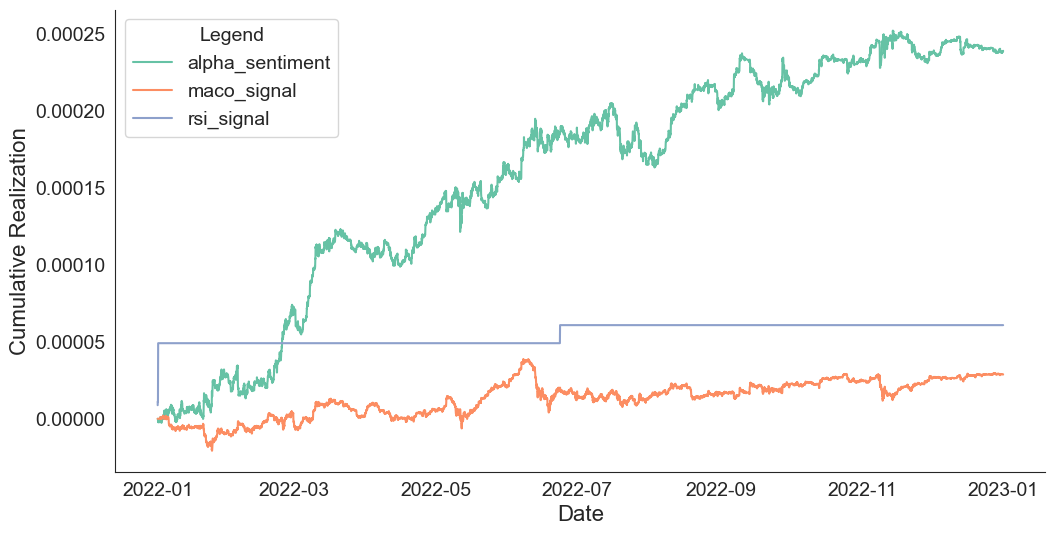

In [52]:
# no num_comments, Y exponential smoothing, Y LDA filtering
from modules.signals import plot_realization
perfs = [c for c in plot_df.columns if "perf" in c]
signals = ["alpha_sentiment", "maco_signal", "rsi_signal"]
plot_realization(plot_df, signals, perfs, "l2", threshold=0.1)

In [17]:
for signal in signals:
    print("Metrics for", signal)
    print(compute_key_metrics(plot_df, signal, perfs))

Metrics for alpha_sentiment
{'sharpe': [2.5311550045168247], 'bias': [-0.00016152192357274942], 'beta': [-0.0002006242592461838]}
Metrics for maco_signal
{'sharpe': [0.6759602110707185], 'bias': [-6.576270720388585e-05], 'beta': [-6.66179863957839e-05]}
Metrics for rsi_signal
{'sharpe': [1.6245637925920504], 'bias': [-0.00018250775067995425], 'beta': [-0.0008795466183437852]}


## Experiments

### Why does `num_comments` not improve the signal?

In [17]:
t = plot_df.copy()
t.index = t["datetime"]

In [18]:
alpha = "alpha_sentiment"
perf = "perf_1"

In [19]:
beta = t[alpha].cov(t[perf]) / t[alpha].var()
t["real"] =  t[alpha] * t[perf] * beta

Text(0, 0.5, 'Number of comments')

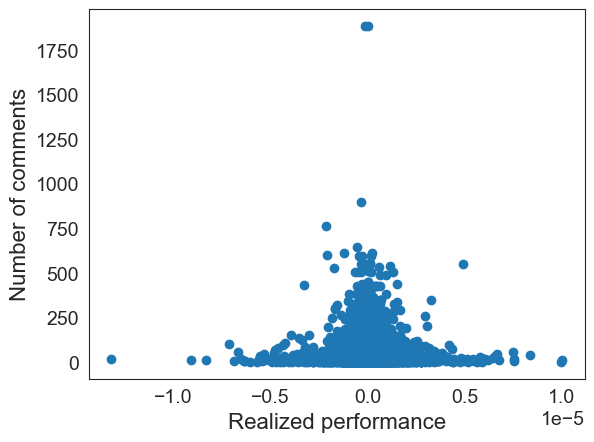

In [20]:
plt.scatter(t["real"], t["num_comments"])
plt.xlabel("Realized performance")
plt.ylabel("Number of comments")

### Is the beta consistent over time? Plot beta_t for all t

In [ ]:
ts = []
betas = []

for t in plot_df["datetime"]:
    ts.append(t)

    df_sub = plot_df.loc[df["datetime"]<=t]
    
    beta = df_sub[alpha].cov(df_sub[perf]) / df_sub[alpha].var()
    # df["real"] =  df_sub[alpha] * df_sub[perf] * beta
    betas.append(beta) 

In [22]:
assert len(ts) == len(betas)

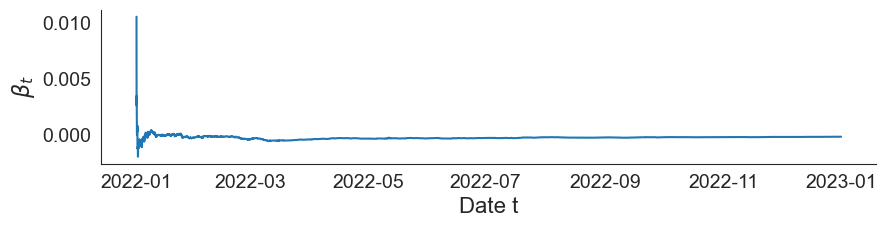

In [40]:
f = plt.figure(figsize=(10, 2))
plt.plot(ts, betas)
sns.despine()
plt.xlabel("Date t")
plt.ylabel(r"$\beta_t$")
plt.show()
f.savefig("beta.pdf", bbox_inches='tight')
# plt.ylabel("Beta computed with time steps up to t")
# plt.title(r"Is $\beta$ stable over time?")